In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import norm
from collections import OrderedDict
import sys, os
from prisk.asset import PowerPlant, WareHouse, Manufacturing
from prisk.flood import FloodExposure, FloodEntitySim
from prisk.firm import Holding
from prisk.portfolio import Portfolio
from prisk.kernel import Kernel
from prisk.insurance import Insurance

In [63]:
# Load CSVs
thailand_assets = pd.read_csv(r"C:\Users\Mark.DESKTOP-UFHIN6T\OneDrive - Nexus365\CFRF\2025\Deals_WG\PRISK\synthetic\synthetic_assets_thailand_flooded.csv")
financial_data = pd.read_csv(r"C:\Users\Mark.DESKTOP-UFHIN6T\OneDrive - Nexus365\CFRF\2025\Deals_WG\PRISK\synthetic\synthetic_owners_thailand.csv")
# Make RP columns int not str1
thailand_assets.columns = thailand_assets.columns.map(lambda c: int(c) if str(c).isdigit() else c)
# Temp (going to just start by running on power assets) - so filter by asset class
thailand_assets = thailand_assets[thailand_assets['asset_class']=='manufacturing']

In [64]:
leverage_ratios = {firm: leverage for firm, leverage in zip(financial_data["owner_name"], financial_data["leverage_ratio"])}
damage_curves = pd.read_excel("https://kuleuven-prisk.s3.eu-central-1.amazonaws.com/damage_curves.xlsx")
return_period_columns = [5, 10, 25, 50, 100, 200, 500, 1000]

In [65]:
def extract_firms(assets, damage_curves=None, leverage_ratios={}, discount_rate=0.05, time_horizon=25):
    assets.sort_values("owner_name", inplace=True)
    if damage_curves is None:
        damage_curves = continuous_curves
    # Create assets for each asset type
    # Starting with power assets
    power_assets = assets[assets['asset_class']=='power'].copy()
    # Power specific variables
    power_unit_price = 60 # pounds per MWh
    power_margin = 0.2 # 20% profit margin for electricity generation
    power_assets.loc[:, "asset"] = power_assets.apply(lambda x: 
                                                PowerPlant(
                                                    name=x["asset_name"],
                                                    flood_damage_curve=damage_curves,
                                                    flood_exposure=[FloodExposure(return_period, x[return_period]) 
                                                                    for return_period in return_period_columns if x[return_period] > 0],
                                                    flood_protection = x["flood_protection"],
                                                    production_path=np.repeat(x["size"]*24*365, time_horizon),
                                                    replacement_cost=x["asset_value_usd"],
                                                    unit_price=power_unit_price,
                                                    discount_rate=discount_rate,
                                                    margin=power_margin,
                                                  ), axis=1)
    # Warehouse
    warehouse_assets = assets[assets['asset_class']=='warehouse'].copy()
    # Warehouse specific variables
    warehouse_unit_price = 100 # pounds p.a. rental income
    warehouse_margin = 0.09 # 9% profit margin of warehouse facilities
    warehouse_assets.loc[:, "asset"] = warehouse_assets.apply(lambda x: 
                                                    WareHouse(
                                                        name=x["asset_name"],
                                                        flood_damage_curve=damage_curves,
                                                        flood_exposure=[FloodExposure(return_period, x[return_period]) 
                                                                        for return_period in return_period_columns if x[return_period] > 0],
                                                        flood_protection = x["flood_protection"],
                                                        production_path=np.repeat(x["size"], time_horizon),
                                                        replacement_cost=x["asset_value_usd"],
                                                        unit_price=warehouse_unit_price,
                                                        discount_rate=discount_rate,
                                                        margin=warehouse_margin,
                                                      ), axis=1)
    # Manufacturing facility
    manufacturing_assets = assets[assets['asset_class']=='manufacturing'].copy()
    # Manufacturing specific variables
    manufacturing_unit_price = 2500 # pounds p.a. production per m^2
    manufacturing_margin = 0.07 # 7% profit margin
    manufacturing_assets.loc[:, "asset"] = manufacturing_assets.apply(lambda x: 
                                                    Manufacturing(
                                                    name=x["asset_name"],
                                                    flood_damage_curve=damage_curves,
                                                    flood_exposure=[FloodExposure(return_period, x[return_period]) 
                                                                    for return_period in return_period_columns if x[return_period] > 0],
                                                    flood_protection = x["flood_protection"],
                                                    production_path=np.repeat(x["size"], time_horizon),
                                                    replacement_cost=x["asset_value_usd"],
                                                    unit_price=manufacturing_unit_price,
                                                    discount_rate=discount_rate,
                                                    margin=manufacturing_margin,
                                                  ), axis=1)
    # Combine these back together
    assets = pd.concat(
        [power_assets, warehouse_assets, manufacturing_assets],
        axis=0,
        ignore_index=True
    )
    
    list_of_owners = []
    for owners in assets["owner_name"].unique():
        if pd.isna(owners):
            continue
        list_of_owners.append(owners)
    list_of_owners = list(OrderedDict.fromkeys(list_of_owners))
    owner_map = {owner: Holding(owner, leverage_ratio=leverage_ratios.get(owner)) for owner in list_of_owners}
    holdings = []
    for i, owner in enumerate(assets["owner_name"]):
        if pd.isna(owner):
            continue
        share = 100 # here assuming each asset only has 1 owner. In original PRISK there could be a multi-ownership structure
        holding = owner_map[owner]
        holding.add_asset(assets.loc[i, "asset"], share)
        holdings.append(holding)
    return list(OrderedDict.fromkeys(holdings)), assets
    
def convert_to_continous_damage(damage_curves):
    continuous_curves = pd.DataFrame({"index": range(0, int(max((damage_curves["depth"] + 0.01)*100)))})
    continuous_curves["index"] = continuous_curves["index"]/100
    continuous_curves.set_index("index", inplace=True)
    continuous_curves = continuous_curves.merge(damage_curves, how="left", left_index=True, right_on="depth")
    continuous_curves.interpolate(method="linear", inplace=True)
    continuous_curves.set_index("depth", inplace=True)
    return continuous_curves

def merton_probability_of_default(V, sigma_V, D, r=0, T=1):
    """
    Calculate the probability of default using the Merton model.

    Parameters:
    V (float): Current value of the company's assets.
    sigma_V (float): Volatility of the company's assets.
    D (float): Face value of the company's debt.
    r (float): Risk-free interest rate.
    T (float): Time to maturity of the debt.

    Returns:
    float: Probability of default.
    """
    # Calculate d2
    d2 = (np.log(V / D) + (r - 0.5 * sigma_V**2) * T) / (sigma_V * np.sqrt(T))
    # Calculate the probability of default
    PD = norm.cdf(-d2)
    return PD

#### Flood Simulations

In [118]:
# Function for running simulation
def simulation_run(assets, damage_curves, leverage_ratios, Ins_Cap, n_sims, sigma, insured=False, adaptation=False):
    # Prepare simulation
    # Apply protection
    assets = assets.copy() # make sure that we are using a new df each time (fp isn't permanently written)
    if adaptation:
        assets.loc[:, "flood_protection"] = adaptation
    # Create continuous damage curves
    continuous_curves = convert_to_continous_damage(damage_curves)
    # Extract assets
    firms, processed_assets = extract_firms(assets, damage_curves=continuous_curves, leverage_ratios=leverage_ratios)
    # Construct portfolio
    portfolio = Portfolio("Simulation Portfolio")
    nav = 1
    for firm in firms:
        portfolio.add_position(firm, nav/(len(firms)*firm.npv)) # equal firm weighting in portfolio

    # Run simulation
    np.random.seed(0)
    portfolio_values = []
    merton_values = []
    for i in tqdm(range(n_sims)):
        assets = processed_assets.asset.to_list().copy()
        insurer = Insurance("Insurance company", capital=Ins_Cap, subscribers=[])
        kernel = Kernel(assets=assets, insurers=[insurer])
        for asset in assets:
            if insured:
                asset.add_insurer(insurer)
            # Flood entity sim simulates floods at the asset-level without considering other asset events
            FloodEntitySim(asset).simulate(time_horizon=25, kernel=kernel)
        kernel.run(time_horizon=25, verbose=1)
        portfolio_values.append(portfolio.underlying_value)
        merton_pds = [-merton_probability_of_default(V=firm.base_value, sigma_V=sigma, D=firm.original_liabilities)
                       + merton_probability_of_default(V=firm.npv, sigma_V=sigma, D=firm.original_liabilities)
                     for firm in firms]
        merton_values.append(merton_pds)
        for asset in assets:
            asset.reset() # Reset assets to their original state
    
    return portfolio_values, merton_values

In [119]:
# Run baseline and adapted
n_sims = 1
adapt_protec = 15
insured = False
ins_cap = 2e9
sigma = 0.2
baseline_pvs, baseline_pds = simulation_run(thailand_assets, damage_curves, leverage_ratios, ins_cap, n_sims, sigma, insured, False)
adapted_pvs, adapted_pds = simulation_run(thailand_assets, damage_curves, leverage_ratios, ins_cap, n_sims, sigma, insured, adapt_protec)

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

Starting simulation
-------------------
Adding End of Year events...
Flood event at year 0 at Manufacturing Asset 00570 with depth 3.14
Flood event at year 0 at Manufacturing Asset 00540 with depth 2.88
Flood event at year 0 at Manufacturing Asset 00523 with depth 2.04
Flood event at year 0 at Manufacturing Asset 00198 with depth 3.69
Flood event at year 0 at Manufacturing Asset 00315 with depth 2.15
Flood event at year 0 at Manufacturing Asset 00624 with depth 0.77
Flood event at year 0 at Manufacturing Asset 00172 with depth 7.95
Flood event at year 0 at Manufacturing Asset 00374 with depth 0.79
Flood event at year 0 at Manufacturing Asset 00218 with depth 1.62
Flood event at year 0 at Manufacturing Asset 00395 with depth 3.38
Flood event at year 0 at Manufacturing Asset 00180 with depth 3.31
Flood event at year 0 at Manufacturing Asset 00734 with depth 7.58
Flood event at year 0 at Manufacturing Asset 00749 with depth 1.53
Flood event at year 0 at Manufacturing Asset 00212 with dept

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

Starting simulation
-------------------
Adding End of Year events...
Flood event at year 0 at Manufacturing Asset 00570 with depth 3.14
Flood event at year 0 at Manufacturing Asset 00540 with depth 2.88
Flood event at year 0 at Manufacturing Asset 00523 with depth 2.04
Flood event at year 0 at Manufacturing Asset 00198 with depth 3.69
Flood event at year 0 at Manufacturing Asset 00315 with depth 2.15
Flood event at year 0 at Manufacturing Asset 00624 with depth 0.77
Flood event at year 0 at Manufacturing Asset 00172 with depth 7.95
Flood event at year 0 at Manufacturing Asset 00374 with depth 0.79
Flood event at year 0 at Manufacturing Asset 00218 with depth 1.62
Flood event at year 0 at Manufacturing Asset 00395 with depth 3.38
Flood event at year 0 at Manufacturing Asset 00180 with depth 3.31
Flood event at year 0 at Manufacturing Asset 00734 with depth 7.58
Flood event at year 0 at Manufacturing Asset 00749 with depth 1.53
Flood event at year 0 at Manufacturing Asset 00212 with dept

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.21it/s]


Text(0, 0.5, 'Count')

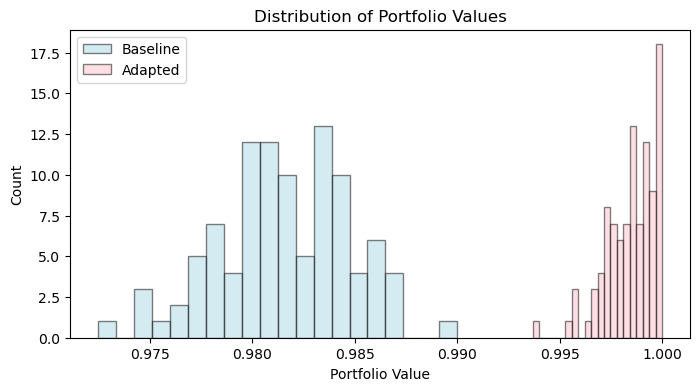

In [117]:
# Plot figures
fig, ax = plt.subplots(figsize=(8, 4))
# (PRISK)
ax.hist(baseline_pvs, bins=20, density=False, alpha=0.5, color='lightblue', edgecolor='black', label='Baseline')
ax.hist(adapted_pvs, bins=20, density=False, alpha=0.5, color='pink', edgecolor='black', label='Adapted')
ax.set_title("Distribution of Portfolio Values")
ax.set_xlabel("Portfolio Value")
ax.legend()
# ax.set_xlim(0.996, 1)
ax.set_ylabel("Count")

In [52]:
print('Baseline Average Impact:', np.mean(baseline_pvs))
print('Baseline VaR 99%:', np.quantile(baseline_pvs, 0.01))
print('Adapted Average Impact:', np.mean(adapted_pvs))
print('Adapted VaR 99%:', np.quantile(adapted_pvs, 0.01))

Baseline Average Impact: 0.9992196000000001
Baseline VaR 99%: 0.9974
Adapted Average Impact: 0.9991993
Adapted VaR 99%: 0.9974


## OLD SCRATCH STUFF

In [ ]:
# continuous_curves = convert_to_continous_damage(damage_curves)
# firms, processed_assets = extract_firms(thailand_assets, damage_curves=continuous_curves, leverage_ratios=leverage_ratios)

# # Construct portfolio
# portfolio = Portfolio("Thailand Assets")
# nav = 1 
# for firm in firms:
#     portfolio.add_position(firm, nav/(len(firms)*firm.npv)) # equal firm weighting in portfolio

# hybas_basins = "https://kuleuven-prisk.s3.eu-central-1.amazonaws.com/hybas_as_lev06_v1c.shp"
# basin_outlet_file = "https://kuleuven-prisk.s3.eu-central-1.amazonaws.com/lev06_outlets_final_clipped_Thailand_no_duplicates.csv"

# flood_protection = 100
# insured = False
# insurer_capital = 2e9
# simulations = 100
# country = "Thailand"
# random_seed = 0
# sigma=0.2

# asset_run = thailand_assets.copy()
# if flood_protection:
#     asset_run.loc[:, "flood_protection"] = asset_run[flood_protection]

# continuous_curves = convert_to_continous_damage(damage_curves)
# firms, processed_assets = extract_firms(asset_run, damage_curves=continuous_curves, leverage_ratios=leverage_ratios)

# # Construct portfolio
# portfolio = Portfolio("Thailand Assets")
# nav = 1 
# for firm in firms:
#     portfolio.add_position(firm, nav/(len(firms)*firm.npv)) # equal firm weighting in portfolio

# # Complete Independence
# np.random.seed(0)
# portfolio_values = []
# merton_independence = []
# for i in tqdm(range(simulations)):
#     assets = processed_assets.asset.to_list().copy()
#     insurer = Insurance("Insurance company", capital=insurer_capital, subscribers=[])
#     kernel = Kernel(assets=assets, insurers=[insurer])
#     for asset in assets:
#         if insured:
#             asset.add_insurer(insurer)
#         # The flood entity sim simulates floods at the asset-level without considering other asset events
#         FloodEntitySim(asset).simulate(time_horizon=25, kernel=kernel)
#     kernel.run(time_horizon=25, verbose=0) # time horizon: 25 years, the remainder will be included in TV
#     portfolio_values.append(portfolio.underlying_value)
#     merton_pds = [-merton_probability_of_default(V=firm.base_value, sigma_V=sigma, D=firm.original_liabilities)
#                     + merton_probability_of_default(V=firm.npv, sigma_V=sigma, D=firm.original_liabilities)   
#                 for firm in firms]
#     merton_independence.append(merton_pds)
#     for asset in assets:
#         asset.reset() # Reset the assets to their initial state

# merton_avg = [np.mean(mert) for mert in merton_independence]